In [560]:
# YIKAI MAO

# quantum communication algorithm generator

In [561]:
# reproducibility
%env PYTHONHASHSEED=0

# Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, Aer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from qiskit.transpiler.passes import RemoveBarriers
from qiskit.circuit.library import Diagonal, QFT, GroverOperator, ZGate
from qiskit.quantum_info import Statevector, random_statevector
from qiskit.extensions import Initialize

print('*'*104)
print("available simulators:")
display(Aer.backends())
print('*'*104)

# other libraries
from tqdm import tqdm #tqdm(iterable)
from random import sample
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as trans
from sklearn.metrics import r2_score
import pickle

env: PYTHONHASHSEED=0
********************************************************************************************************
available simulators:


[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

********************************************************************************************************


In [562]:
# utility functions

def run_ideal_simulation(circuit, shots, optimization_level, seed, show_plot, show_counts):
    # assume perfect device with no noise
    # circuit = circuit to simulate, not transpiled
    # shots = how many shots to run
    # optimization_level = passed to the transpiler, min = 0, max = 3
    # seed = random seed for simultaion, can be None
    # show_counts = T/F, plot result or not

    simulator = Aer.get_backend('aer_simulator')
    temp_qc = transpile(circuit, simulator, optimization_level=optimization_level)
    job_temp = simulator.run(temp_qc, shots=shots, seed_simulator=seed)
    temp_results = job_temp.result()
    
    # build simulation result dict
    raw_counts = temp_results.get_counts()
    # print("raw counts:\n", raw_counts)
    num_clbits = circuit.num_clbits
    ideal_result_dict = {}

    # sorting the raw counts, add state zero
    for i in range(pow(2, num_clbits)):
        bin_str = format(i, str('0>' + str(num_clbits) + 'b'))
        if bin_str not in raw_counts:
            ideal_result_dict[bin_str] = 0
        else:
            ideal_result_dict[bin_str] = raw_counts[bin_str]

    if show_plot:
        plot = plot_histogram(raw_counts, title='ideal simulation')
        display(plot)
            
    if show_counts:
        print('sorted counts:')
        print(ideal_result_dict)
    
    return ideal_result_dict, raw_counts

def decomposer(circ, level=1):
    # decompose the circuit to see the basis gates
    # level = how many times to decompose
    
    decomposed_circ = circ
    
    for i in range(level):
        decomposed_circ = decomposed_circ.decompose()
        
    return decomposed_circ

# https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def random_bin_str(width, zero=False):
    # return random binary string based on width
    # zero = T/F, T = include 0, F = do not return 0
    # width cannot be 0
    
    if width == 0:
        return None
    
    b = np.random.randint(2, size=width)
    b_str = ''.join(map(str, b.tolist()))
    
    if zero==True:
        return b_str
    
    else:
        while '1' not in b_str:
            b = np.random.randint(2, size=width)
            b_str = ''.join(map(str, b.tolist()))
        
        return b_str

In [563]:
# https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/quantum-key-distribution.ipynb

def encode_message(n, bits, bases):
    
    encoder = QuantumCircuit(n)
    
    for i in range(n):
        
        # Prepare qubit in Z-basis
        if bases[i] == '0':
            if bits[i] == '0':
                pass 
            else:
                encoder.x(i)
                
        # Prepare qubit in X-basis
        else:
            if bits[i] == '0':
                encoder.h(i)
            else:
                encoder.x(i)
                encoder.h(i)
    
    encoder = encoder.to_gate(label='encoder')
    
    return encoder

def decode_message(n, bases):
    
    decoder = QuantumCircuit(n)
    
    for i in range(n):
        
        # measuring in Z-basis
        if bases[i] == '0':
            pass
        
        # measuring in X-basis
        if bases[i] == '1':
            decoder.h(i)
    
    decoder = decoder.to_gate(label='decoder')
    
    return decoder

def remove_garbage(n, a_bases, b_bases, bits):
    good_bits = []
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            # If both used the same basis, add
            # this to the list of 'good' bits
            good_bits.append(bits[q])
    return good_bits

def sample_bits(bits, selection):
    sample = []
    for i in selection:
        # use np.mod to make sure the
        # bit we sample is always in 
        # the list range
        i = np.mod(i, len(bits))
        # pop(i) removes the element of the
        # list at index 'i'
        sample.append(bits.pop(i))
    return sample

def quantum_key_distribution(n, options=[]):
    # n is problem size, NOT necessarily equal to the qubit count of the generated circuit
    # options = [interception, play]
    # interception = T/F, with/without eve's interception
    # play = T/F, print message/base/measurements to play a round of key distribution
    
    interception = options[0]
    play = options[1]
    
    quantum_key_distribution_circuit = QuantumCircuit(n,n)
    
    # step 1
    alice_bits = random_bin_str(n, True)
    alice_bases = random_bin_str(n, True)
    message = encode_message(n, alice_bits, alice_bases)
    if play:
        print('alice message =', alice_bits)
        print('alice bases =  ', alice_bases)
        
    # step 2
    quantum_key_distribution_circuit.append(message, list(range(n)))
    quantum_key_distribution_circuit.barrier()
    
    # interception
    if interception:
        eve_bases = random_bin_str(n, True)
        quantum_key_distribution_circuit.append(decode_message(n, eve_bases), list(range(n)))
        quantum_key_distribution_circuit.barrier()
        for i in range(n):
            quantum_key_distribution_circuit.measure(i, i)
        quantum_key_distribution_circuit.barrier()

        if play:
            sorted_counts, raw_counts = run_ideal_simulation(quantum_key_distribution_circuit, 1, 0, None, False, False)
            # reversed for qiskit endian
            eve_message = str(list(raw_counts.items())[0][0])[::-1]
            print('eve interception =', eve_message)
    
    # step 3
    bob_bases = random_bin_str(n, True)
    quantum_key_distribution_circuit.append(decode_message(n, bob_bases), list(range(n)))
    quantum_key_distribution_circuit.barrier()
    for i in range(n):
        quantum_key_distribution_circuit.measure(i, i)
    if play:
        print('bob bases =  ', bob_bases)
    
    # step 4
    if play:
        sorted_counts, raw_counts = run_ideal_simulation(quantum_key_distribution_circuit, 1, 0, None, False, False)
        # reversed for qiskit endian
        bob_message = str(list(raw_counts.items())[0][0])[::-1]
        print('bob message =', bob_message)

        alice_key = remove_garbage(n, alice_bases, bob_bases, alice_bits)
        bob_key = remove_garbage(n, alice_bases, bob_bases, bob_message)
        print('alice key =', alice_key)
        print('bob key =  ', bob_key)
    
    # step 5
    if play:
        # Change this to something lower and see if 
        # Eve can intercept the message without Alice
        # and Bob finding out
        sample_size = 2
        
        bit_selection = np.random.randint(n, size=sample_size)
        alice_sample = sample_bits(alice_key, bit_selection)
        bob_sample = sample_bits(bob_key, bit_selection)
        print('alice sample =', alice_sample)
        print('bob sample   =', bob_sample)

        if bob_sample != alice_sample:
            print("Eve's interference was detected.")
        else:
            print("Eve went undetected! (or no interception)")
    
    return quantum_key_distribution_circuit

In [564]:
# https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/superdense-coding.ipynb

def entangle(n):
    # entange multiple qubits
    # n must >= 2
    
    qc = QuantumCircuit(n)
    
    qc.h(0)
    for i in range(n-1):
        qc.cx(i, i+1)
    
    qc = qc.to_gate(label='entangle')
    
    return qc

def encode_message_superdense(n, size):
    
    qc = QuantumCircuit(n)
    if size == 'half':
        size = int(round(n/2))
    elif size == 'all':
        size = n
    else:
        size = size
    message_index = sample(range(n), size)
    # print(message_index)
    
    for i in message_index:
        message = np.random.randint(4)
        # print(i,message)
        if message == 0:
            qc.id(i)
        if message == 1:
            qc.x(i)
        if message == 2:
            qc.z(i)
        if message == 3:
            qc.x(i)
            qc.z(i)
            
    qc = qc.to_gate(label='message')
            
    return qc

def disentangle(n):
    # disentange multiple qubits
    # n must >= 2
    
    qc = QuantumCircuit(n)
    
    for i in range(n-1):
        qc.cx(n-2-i, n-1-i)
    qc.h(0)
        
    qc = qc.to_gate(label='disentangle')
        
    return qc

def superdense_coding(n, options=[]):
    # n is problem size, NOT necessarily equal to the qubit count of the generated circuit
    # options = [size]
    # size = 'all': encode all qubits. 'half': encode half qubits. or just provide a number, must <= n
    
    size = options[0]
    
    superdense_coding_circuit = QuantumCircuit(n)

    # entanglement
    superdense_coding_circuit.append(entangle(n),list(range(n)))
    
    superdense_coding_circuit.barrier()
    
    # encode qubits
    superdense_coding_circuit.append(encode_message_superdense(n, size),list(range(n)))
    
    superdense_coding_circuit.barrier()
    
    # disentanglement
    superdense_coding_circuit.append(disentangle(n),list(range(n)))
    
    superdense_coding_circuit.measure_all()

    return superdense_coding_circuit

In [565]:
def quantum_teleportation(n, options=[]):
    # n is problem size, NOT necessarily equal to the qubit count of the generated circuit
    # options = [state]
    # state = specify the state to teleport (state=Statevector([0, 1])), or 'random'
        
    state = options[0]
        
    quantum_teleportation_circuit = QuantumCircuit(3*n,1*n)

    for i in range(n):
    
        offset = 3*i
        if state == 'random':
            s = random_statevector(2)
            init_gate = QuantumCircuit(1).compose(Initialize(s), front = True, inplace = False).to_instruction(label='init')
        else:
            init_gate = QuantumCircuit(1).compose(Initialize(state), front = True, inplace = False).to_instruction(label='init')
        inverse_init = QuantumCircuit(1).compose(Initialize(s).gates_to_uncompute(), front = True, inplace = False).to_instruction(label='disentangle')
        
        # First, let's initialize Alice's q0
        quantum_teleportation_circuit.append(init_gate, [0+offset])
        quantum_teleportation_circuit.barrier(0+offset,1+offset,2+offset)
        
        # Now begins the teleportation protocol
        quantum_teleportation_circuit.h(1+offset)
        quantum_teleportation_circuit.cx(1+offset,2+offset)
        quantum_teleportation_circuit.barrier(0+offset,1+offset,2+offset)
        
        # Send q1 to Alice and q2 to Bob
        quantum_teleportation_circuit.cx(0+offset,1+offset)
        quantum_teleportation_circuit.h(0+offset)
        quantum_teleportation_circuit.barrier(0+offset,1+offset,2+offset)
        
        # Alice sends classical bits to Bob
        quantum_teleportation_circuit.cx(1+offset,2+offset)
        quantum_teleportation_circuit.cz(0+offset,2+offset)
        
        # We undo the initialization process
        quantum_teleportation_circuit.append(inverse_init, [2+offset])
        
        # See the results, we only care about the state of qubit 2
        quantum_teleportation_circuit.measure(2+offset,i)
    
    return quantum_teleportation_circuit

alice message = 0001000010
alice bases =   1100101001
eve interception = 0001001000
bob bases =   0010111011
bob message = 0011101101
alice key = ['1', '0', '0', '0', '0']
bob key =   ['1', '1', '1', '1', '1']
alice sample = ['0', '1']
bob sample   = ['1', '1']
Eve's interference was detected.


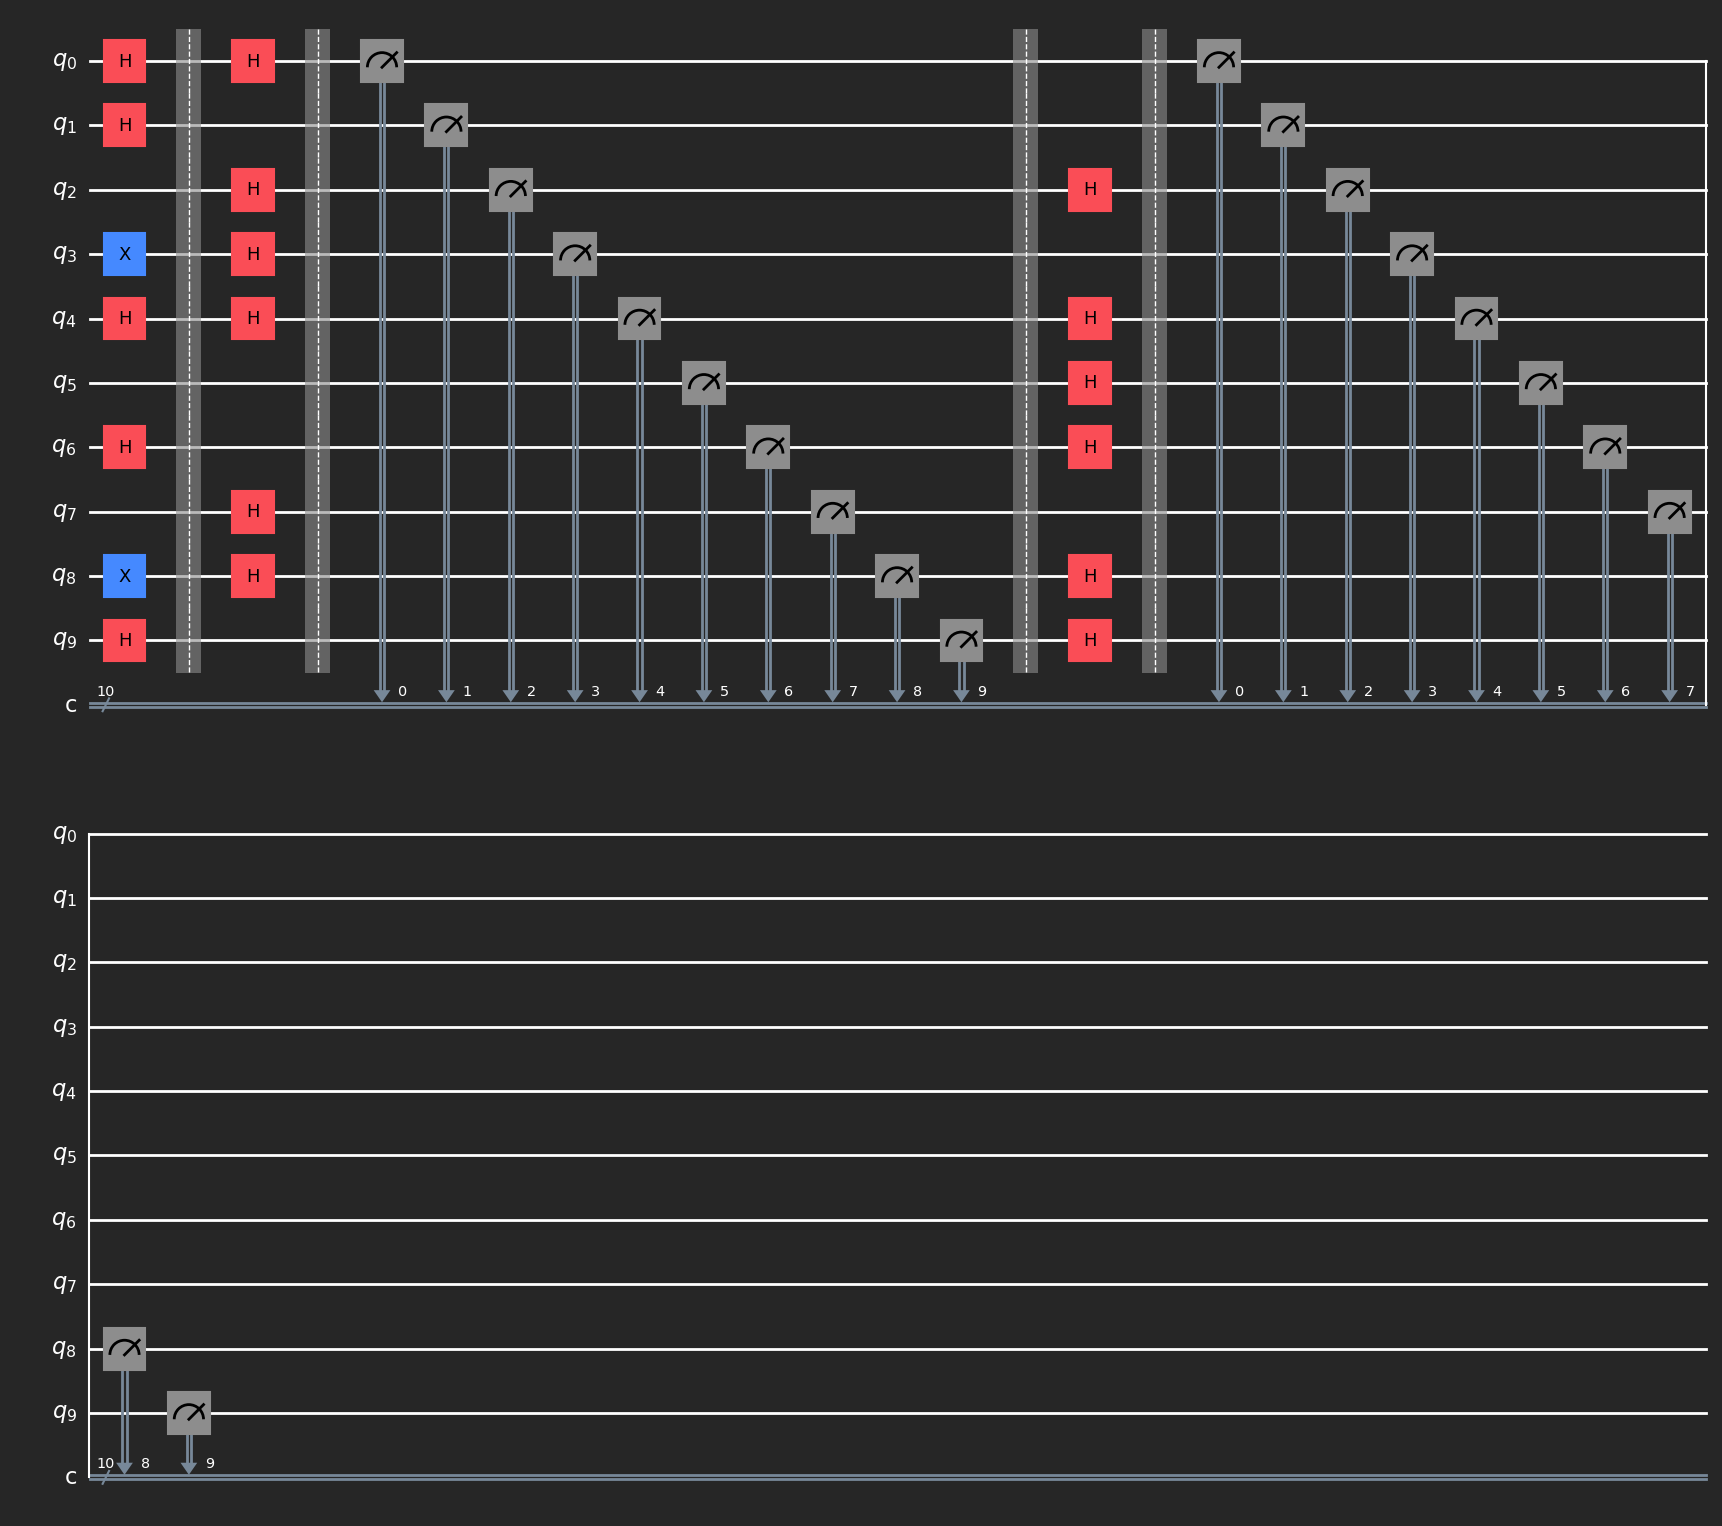

In [567]:
n = 10
interception = True
play = True

quantum_key_distribution_circuit = quantum_key_distribution(n, [interception, play])

decomposer(quantum_key_distribution_circuit, 1).draw(style="iqp-dark") #iqp, iqp-dark, textbook, bw, clifford

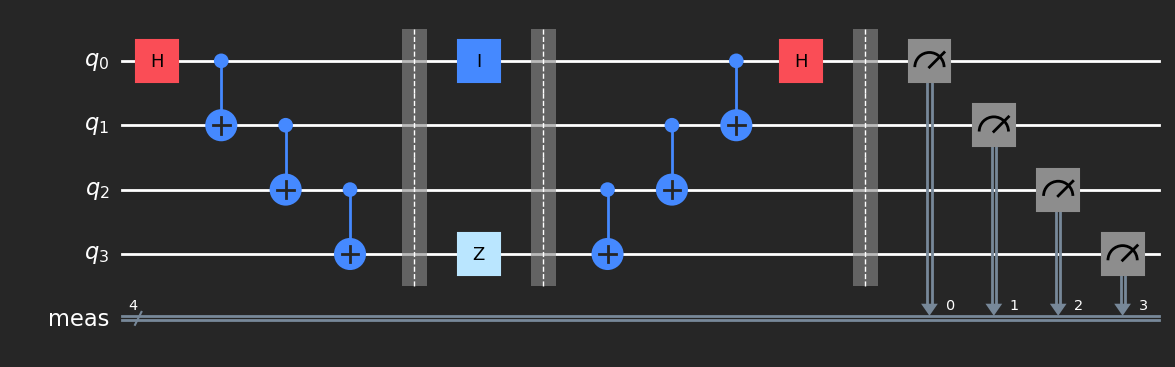

In [571]:
n = 4
size = 'half'

superdense_coding_qc = superdense_coding(n, [size])

decomposer(superdense_coding_qc, 1).draw(style="iqp-dark") #iqp, iqp-dark, textbook, bw, clifford

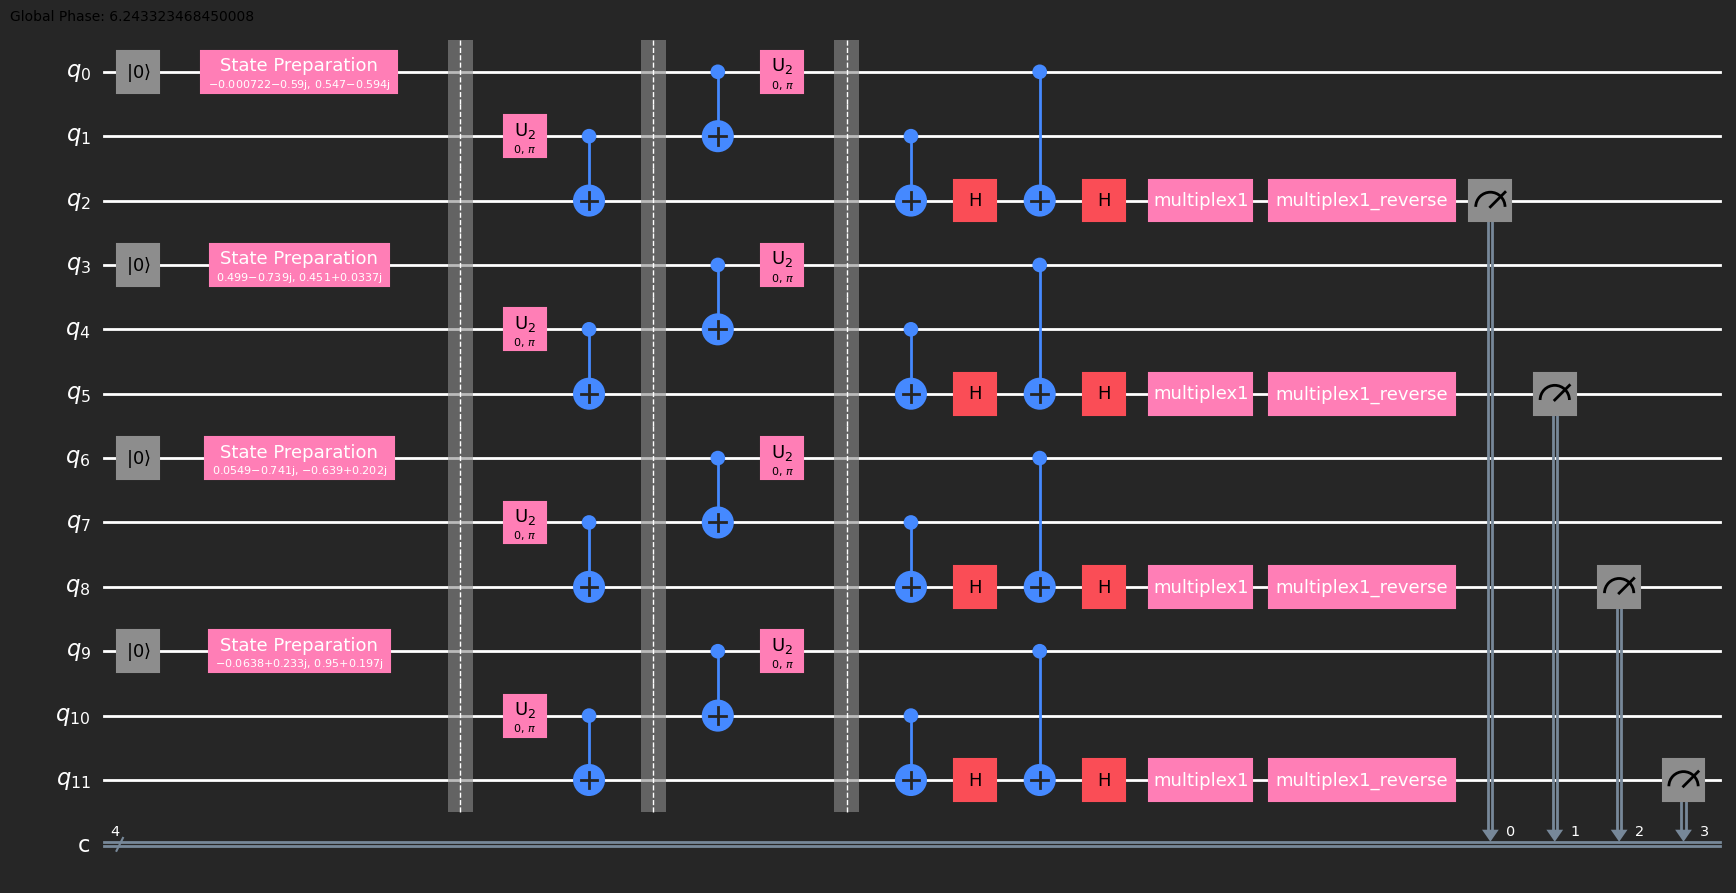

In [573]:
n = 4
state = 'random'

quantum_teleportation_qc = quantum_teleportation(n, [state])

decomposer(quantum_teleportation_qc, 1).draw(style="iqp-dark") #iqp, iqp-dark, textbook, bw, clifford

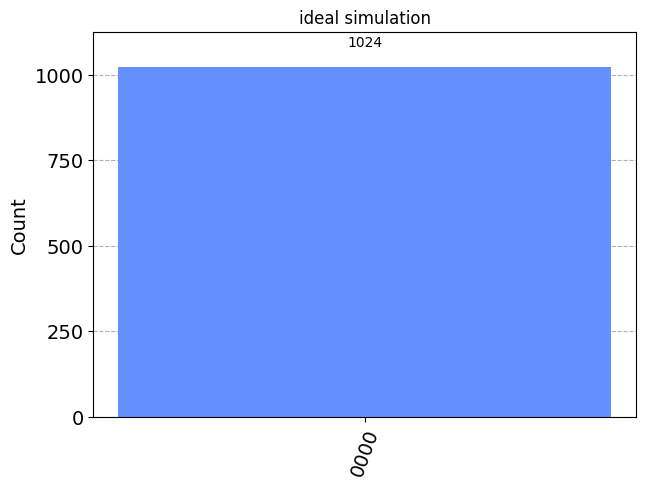

CPU times: user 3.46 s, sys: 130 ms, total: 3.59 s
Wall time: 183 ms


In [574]:
%%time

qc = quantum_teleportation_qc
shots = 1024
optimization_level = 0
seed = None
show_plot = True
show_counts = False

sorted_counts, raw_counts = run_ideal_simulation(qc, shots, optimization_level, seed, show_plot, show_counts)